# Прогноз прибыли для нефтяных скважин

В условной нефтедобывающей компании необходимо решить, где бурить новую скважину. В распоряжении данные проб нефти в трёх регионах. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
state = np.random.RandomState(12345) 

## Загрузка и подготовка данных

In [2]:
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    df_0 = pd.read_csv('geo_data_0.csv')

In [3]:
try:
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    df_1 = pd.read_csv('geo_data_1.csv')

In [4]:
try:
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_2 = pd.read_csv('geo_data_2.csv')

In [5]:
def review(df): 
    """функция для отображения общей информации"""
    info = display(df.head(10)), df.info(), display(df.describe(), df.corr()) 

In [6]:
def dupl(df):
    """функция для подсчета дубликатов"""
    if df_0.duplicated().sum() == 0:
        print('Дубликатов не обнаружено')
    else:
        print('Дубликатов найдено: {}'.format(df_0.duplicated().sum()))

In [7]:
def boxplot(df):
    """функция для построения коробок с усами"""
    sns.boxplot(x = df)  
    sns.set_style('darkgrid')
    plt.show()

### Проверяем регион df_0

In [8]:
review(df_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [9]:
dupl(df_0)

Дубликатов не обнаружено


- данные практически без мусора;
- в столбце `f2` видны выбросы;
- корреляция между столбцами отсутсвует.

Посмотрим на боксплоты.

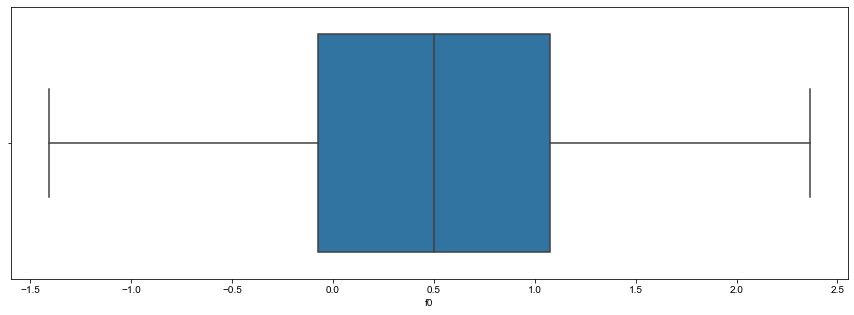

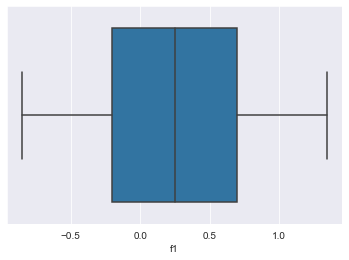

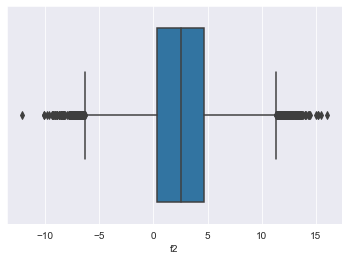

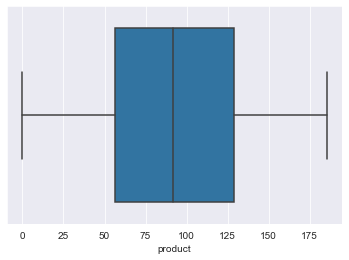

In [10]:
fig, ax = plt.subplots(figsize =(15,5))
boxplot(df_0['f0'])
boxplot(df_0['f1'])
boxplot(df_0['f2'])
boxplot(df_0['product'])

Видим много выбросов в столбце `f2`.

### Проверяем регион df_1

In [11]:
review(df_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [12]:
dupl(df_1)

Дубликатов не обнаружено


- данные практически без мусора;
- в столбце `f1` видны выбросы;
- обнаружена положильная корреляция между столбцами `f2` и `product`

Посмотрим на боксплоты.

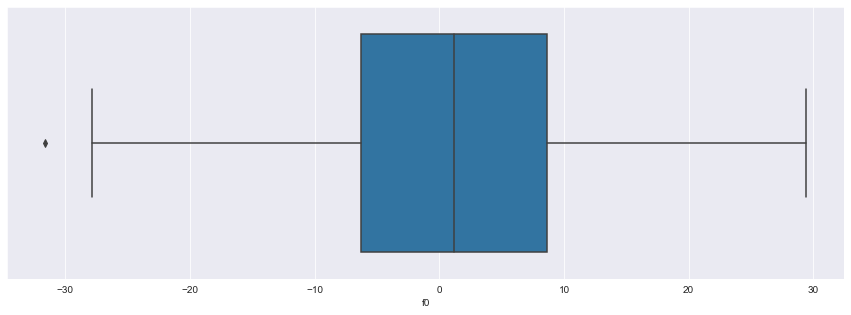

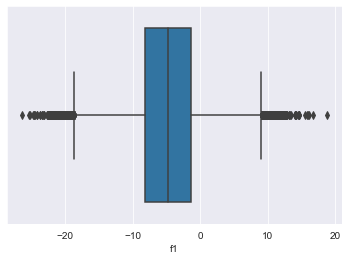

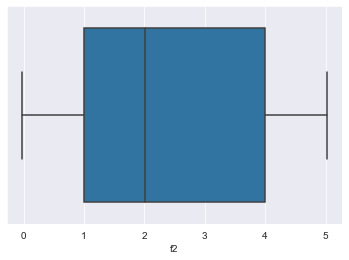

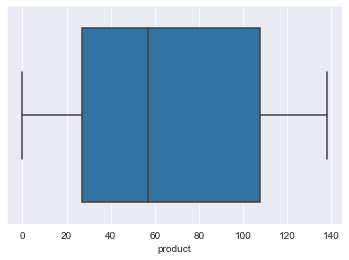

In [13]:
fig, ax = plt.subplots(figsize =(15,5))
boxplot(df_1['f0'])
boxplot(df_1['f1'])
boxplot(df_1['f2'])
boxplot(df_1['product'])

Видим много выбросов в столбце `f1`.

### Проверяем регион df_2

In [14]:
review(df_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [15]:
dupl(df_2)

Дубликатов не обнаружено


- данные практически без мусора;
- в столбце `f0`, `f1`, `f2`, видны выбросы;
- корреляция между столбцами отсутсвует.

Посмотрим на боксплоты.

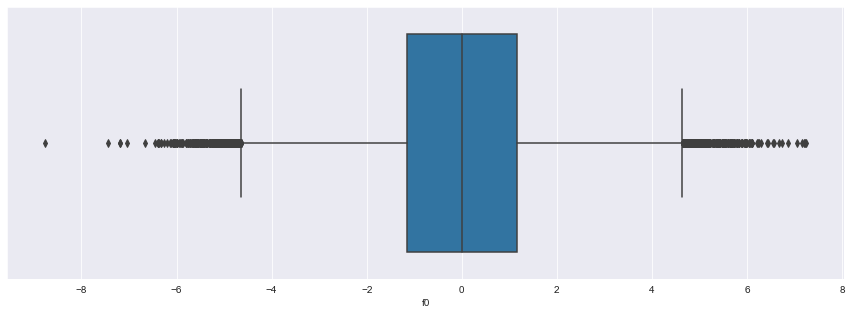

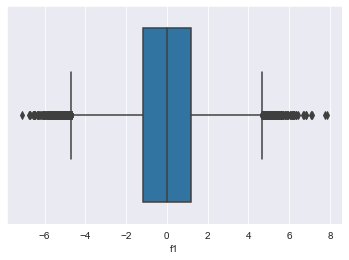

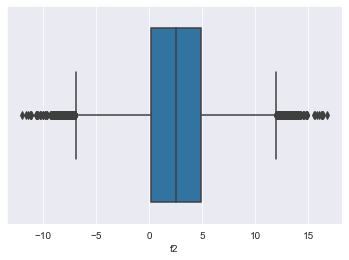

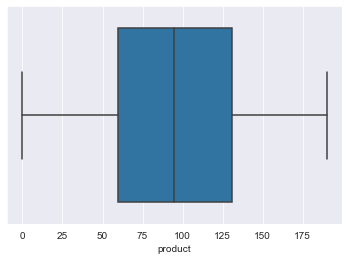

In [16]:
fig, ax = plt.subplots(figsize =(15,5))
boxplot(df_2['f0'])
boxplot(df_2['f1'])
boxplot(df_2['f2'])
boxplot(df_2['product'])

Видим много выбросов в столбце `f0`, `f1`, `f2`.

### Вывод

- данные получены практически без мусора;
- обнаружены выбросы во всех датафреймах;
- обнаружена зависимость данных в столбце `f2` на данные в столбце `product`.

## Обучение и проверка модели

In [17]:
def split_data(features, target):
    """функция для формирования обучающей и валидационной выборок"""
    (features_train, 
     features_valid, 
     target_train, 
     target_valid
    ) = train_test_split(features, 
                         target, 
                         test_size = 0.25, 
                         random_state=12345
                        )
    return (features_train, 
            features_valid, 
            target_train, 
            target_valid
           )

In [18]:
def model_training(features_train, features_valid, target_train, target_valid):
    """функция для обучения и проверки модели"""
    model = LinearRegression() 
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid) 
    predictions_valid = pd.Series(predictions_valid)
    result = mean_squared_error(target_valid_df_0, predictions_valid)**0.5
    scores = cross_val_score(model, features_valid, target_valid, cv=5)
    final_score = sum(scores) / len(scores)
    print('RMSE модели линейной регрессии на валидационной выборке по региону равна {}'.format(result))
    print('Cредний запас предсказанного сырья по региону равен {} тыс. баррелей'.format(predictions_valid.mean()))
    print('Усредненный R2 score модели по региону равен {}'.format(final_score))

In [19]:
def predict(features_train, features_valid, target_train, target_valid):
    """функция для сохранения предсказаний"""
    model = LinearRegression() 
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid) 
    predictions_valid = pd.Series(predictions_valid)
    return predictions_valid

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [20]:
(features_train_df_0, 
 features_valid_df_0, 
 target_train_df_0, 
 target_valid_df_0) = split_data(df_0.drop(['id', 'product'],
                                 axis = 1),
                                 df_0['product']
                                )
(features_train_df_1, 
 features_valid_df_1, 
 target_train_df_1, 
 target_valid_df_1) = split_data(df_1.drop(['id', 'product'],
                                 axis = 1),
                                 df_1['product']
                                )
(features_train_df_2, 
 features_valid_df_2, 
 target_train_df_2, 
 target_valid_df_2) = split_data(df_2.drop(['id', 'product'],
                                 axis = 1),
                                 df_2['product']
                                )

Обучим модель и сделаем предсказания на валидационной выборке. Полученные предсказания и правильные ответы на валидационной выборке сохраним в переменных `target_valid_df_#` и `predictions_valid_df_#`

In [21]:
model_training(features_train_df_0, features_valid_df_0, target_train_df_0, target_valid_df_0)

RMSE модели линейной регрессии на валидационной выборке по региону равна 37.5794217150813
Cредний запас предсказанного сырья по региону равен 92.59256778438008 тыс. баррелей
Усредненный R2 score модели по региону равен 0.27984439304162734


In [22]:
model_training(features_train_df_1, features_valid_df_1, target_train_df_1, target_valid_df_1)

RMSE модели линейной регрессии на валидационной выборке по региону равна 67.91430915635509
Cредний запас предсказанного сырья по региону равен 68.7285468954458 тыс. баррелей
Усредненный R2 score модели по региону равен 0.9996232414326588


In [23]:
model_training(features_train_df_2, features_valid_df_2, target_train_df_2, target_valid_df_2)

RMSE модели линейной регрессии на валидационной выборке по региону равна 48.671457760870574
Cредний запас предсказанного сырья по региону равен 94.96504596800506 тыс. баррелей
Усредненный R2 score модели по региону равен 0.20506479121660134


Сохраните предсказания.

In [24]:
predict_df_0 = predict(features_train_df_0, features_valid_df_0, target_train_df_0, target_valid_df_0)

In [25]:
predict_df_1 = predict(features_train_df_1, features_valid_df_1, target_train_df_1, target_valid_df_1)

In [26]:
predict_df_2 = predict(features_train_df_2, features_valid_df_2, target_train_df_2, target_valid_df_2)

### Вывод

- наибольший средний запас предсказанного сырья у региона `df_2` - `94.96504596800489` тыс. баррелей;
- наименьшая среднеквадратичная ошибка у региона `df_0` - `37.5794217150813`;
- наибольшая оценка качества же у региона `df_1` - `0.9996232414326588`, при этом по остальным показателям данный регион показал сравнительно худшие результаты.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных.

- `COMPANY_TURNOVER` - бюджет на разработку скважин в регионе, руб.;
- `SAMPLE` - выборка точек при разведке региона;
- `BEST_SAMPLE` - выборка наилучших точек, выбранных при помощи машинного обучения;
- `UNIT_INCOME` - доход с каждой единицы продукта, руб.

*Примечание:*

*Вероятность убытков должна составлять меньше 2.5%*

In [27]:
COMPANY_TURNOVER = 10 * (10 ** 9)
SAMPLE = 500
BEST_SAMPLE = 200
UNIT_INCOME = 450000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [28]:
breakeven = (COMPANY_TURNOVER / UNIT_INCOME) / BEST_SAMPLE

In [29]:
print('Достаточный объём добываемого сырья для безубыточной разработки новой скважины равен {} тыс. баррелей'.format(round(breakeven, 2)))

Достаточный объём добываемого сырья для безубыточной разработки новой скважины равен 111.11 тыс. баррелей


Сравним полученный объём сырья со средним запасом предсказанного сырья в каждом регионе.

In [30]:
mean = {"df_0":pd.Series([predict_df_0.mean()]), 
        "df_1":pd.Series([predict_df_1.mean()]),
        "df_2":pd.Series([predict_df_2.mean()]),
        "breakeven":pd.Series([breakeven])
       }
mean_df = pd.DataFrame(mean)
display(mean_df)

,df_0,df_1,df_2,breakeven
0,92.592568,68.728547,94.965046,111.111111


### Вывод

Средний запас сырья в регионах меньше чем безубыточный объем.
- наибольшее запас у региона `df_2`;
- наименьший запас у региона `df_1`.

## Расчёт прибыли и рисков 

Рассчитаем прибыль для 200 скважин с максимальными значениями запаса сырья и предсказаниям модели.

In [31]:
def profit(target_valid, predictions_valid):
    """функция для подсчета прибыли"""
    sort_series = pd.Series(predictions_valid).sort_values(ascending=False)[:BEST_SAMPLE]
    target_valid_sort = (target_valid.reset_index(drop = True)[sort_series.index])
    sum_true = target_valid_sort.sum()
    return ((sum_true * UNIT_INCOME) - COMPANY_TURNOVER).round(2)

### Прибыль по выбранным скважинам региона `df_0`

In [32]:
print('Прибыль для региона равна {} руб.'.format(profit(target_valid_df_0, predict_df_0)))

Прибыль для региона равна 3320826043.14 руб.


### Прибыль по выбранным скважинам региона  `df_1`

In [33]:
print('Прибыль для региона равна {} руб.'.format(profit(target_valid_df_1, predict_df_1)))

Прибыль для региона равна 2415086696.68 руб.


### Прибыль по выбранным скважинам региона  `df_2

In [34]:
print('Прибыль для региона равна {} руб.'.format(profit(target_valid_df_2, predict_df_2)))

Прибыль для региона равна 2710349963.6 руб.


### Вывод

- наибольшая прибыль у региона `df_0`;
- наименьшая прибыль у региона `df_1`.

## Посчитайте риски и прибыль для каждого региона

Применим технику `Bootstrap` с 1000 выборок, чтобы найти распределение прибыли.

In [35]:
def confidence_intervals(target_valid, predictions_valid):
    """функция для подсчета средней выручки, доверительного интервала и рисков"""
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        sort_series = pd.Series(predictions_valid)
        value = sort_series.sample(n = SAMPLE, replace=True, random_state=state)
        values.append(profit(target_valid, value))
    values = pd.Series(values)
    mean = values.mean()
    print('Средняя прибыль для региона равна {}'.format(mean))
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print('95%-й доверительный интервал равен от {} до {}'.format(round(lower,2), round(upper,2)))
    loss_probability = st.percentileofscore(values, 0)
    print('Вероятность убытков для региона равна {}%'.format(round(loss_probability,2)))

### Расчет для региона `df_0`

In [36]:
confidence_intervals(target_valid_df_0, predict_df_0)

Средняя прибыль для региона равна 396164984.80227965
95%-й доверительный интервал равен от -111215545.89 до 909766941.55
Вероятность убытков для региона равна 6.9%


### Расчет для региона `df_1`

In [37]:
confidence_intervals(target_valid_df_1, predict_df_1)

Средняя прибыль для региона равна 456045105.78666013
95%-й доверительный интервал равен от 33820509.4 до 852289453.86
Вероятность убытков для региона равна 1.5%


### Расчет для региона `df_2`

In [38]:
confidence_intervals(target_valid_df_2, predict_df_2)

Средняя прибыль для региона равна 404403866.5683801
95%-й доверительный интервал равен от -163350413.39 до 950359574.93
Вероятность убытков для региона равна 7.6%


### Вывод

Только один регион проходит по условию - вероятность убытков должна составлять меньше 2.5% 
- `df_1` с вероятностью убытков в 1,5% и средней прибылью для региона в `456045105.78665996` руб.
- у регионов `df_0` и `df_2` вероятность убытков от 6,9% до 7,6%.


## Вывод

1. Изначально данный поступают в чистом виде, без артефактов и мусора.
2. Необходимо запросить информацию у дата инженеров по поводу выбросов в некоторых столбцах и сообщить том, что в регионе `df_1` между столбцом `f2` и `product` замечена высокая положительная коррекляция.
3. Для обучения использовалась модель линейной регрессии `LinearRegression`:
- наибольший средний запас предсказанного сырья у региона `df_2` - `94.96504596800489` тыс. баррелей;
- наименьшая среднеквадратичная ошибка у региона `df_0` - `37.5794217150813`;
- наибольшая оценка качества же у региона `df_1` - `0.9996232414326588`, при этом по остальным показателям данный регион показал сравнительно худшие результаты.
4. Средний запас сырья в регионах меньше чем безубыточный объем:
- наибольшее запас у региона `df_2`;
- наименьший запас у региона `df_1`.
5. Только один регион проходит по условию - вероятность убытков должна составлять меньше 2.5% - `df_1`:
- `df_1` с вероятностью убытков в 1,5% и средней прибылью для региона в `456045105.78665996` руб.
- у регионов `df_0` и `df_2` вероятность убытков от 6,9% до 7,6%.